# Importing libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from Handler.cut_functions import *
import sys
import yaml
import argparse
import pandas as pd
import os

In [3]:
%matplotlib inline

# Set system path

In [4]:
current_dir = os.getcwd()
sys.path.append(current_dir)
path = os.path.abspath(sys.path[-1])

# Reading the configuration file

In [5]:
if get_os() == "Mac":
    config_file_name = "mac.cfg"
elif get_os() == "Windows":
    config_file_name = "windows.cfg"
elif get_os() == "Linux":
    config_file_name = "LMU.cfg"
else:
    raise f"OS Error: {get_os()}"

parser = argparse.ArgumentParser(description='Start create balrog training dataset')
parser.add_argument(
    '--config_filename',
    "-cf",
    type=str,
    nargs=1,
    required=False,
    default=config_file_name,
    help='Name of config file'
)
args, unknown = parser.parse_known_args()

if isinstance(args.config_filename, list):
    args.config_filename = args.config_filename[0]

with open(f"{path}/config/{args.config_filename}", 'r') as fp:
    cfg = yaml.load(fp, Loader=yaml.Loader)

# Add some functions

In [6]:
def apply_cuts(cfg, data_frame):
    """"""
    data_frame = unsheared_object_cuts(data_frame=data_frame)
    data_frame = flag_cuts(data_frame=data_frame)
    data_frame = unsheared_shear_cuts(data_frame=data_frame)
    data_frame = binary_cut(data_frame=data_frame)
    data_frame = mask_cut(data_frame=data_frame, master=f"{cfg['PATH_DATA']}/{cfg['FILENAME_MASTER_CAT']}")
    # if cfg["MOCK_APPLY_MAG_CUTS_BEFORE"] is True:
    data_frame = unsheared_mag_cut(data_frame=data_frame)
    return data_frame

In [7]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

# Data Preprocessing

## Load Data

In [8]:
df_balrog = open_all_balrog_dataset(f"{cfg['PATH_DATA']}/{cfg['FILENAME_MERGED_CAT']}")
df_balrog = df_balrog[df_balrog["detected"] == 1]
df_balrog.rename(columns={"ID": "true_id"}, inplace=True)
print(df_balrog)

                    bal_id    true_id  detected     true_ra   true_dec  \
0             100156035400  691667161         1   29.247997 -35.401742   
1             102037044570  691667161         1  309.631288 -45.133897   
2             100530030400  691667161         1   83.027200 -30.858628   
3             100010040400  691667161         1    2.324426 -40.370944   
4             100521042490  691667161         1   80.463712 -42.748836   
...                    ...        ...       ...         ...        ...   
26442011  1006110391413067  713198821         1   93.037734 -38.904808   
26442021  1005550491413068  713198833         1   88.957615 -49.210830   
26442029  1022230470613069  713198833         1  336.043413 -46.800077   
26442105  1003140354013071  713198866         1   48.359363 -35.539977   
26442115  1001160004113066  713198876         1   19.515271  -0.705690   

          match_flag_1.5_asec  flags_foreground  flags_badregions  \
0                           0             

## Calculate colors

In [9]:
df_balrog = calc_color(
    cfg=cfg,
    data_frame=df_balrog,
    mag_type=("MAG", "BDF"),
    flux_col=("BDF_FLUX_DERED_CALIB", "BDF_FLUX_ERR_DERED_CALIB"),
    mag_col=("BDF_MAG_DERED_CALIB", "BDF_MAG_ERR_DERED_CALIB"),
    bins=cfg['BDF_BINS'],
    save_name=f"bdf_mag"
)
df_balrog = calc_color(
    cfg=cfg,
    data_frame=df_balrog,
    mag_type=("MAG", "unsheared"),
    flux_col=("unsheared/flux", "unsheared/flux_err"),
    mag_col=("unsheared/mag", "unsheared/mag_err"),
    bins=cfg['UNSHEARED_BINS'],
    save_name=f"unsheared/mag"
)

## Do some calculations

In [10]:
df_balrog["BDF_G"] = np.sqrt(df_balrog["BDF_G_0"] ** 2 + df_balrog["BDF_G_1"] ** 2)
for bin in cfg["UNSHEARED_BINS"]:
    df_balrog[f"flux_diff_{bin}"] = df_balrog[f"unsheared/flux_{bin}"].values - df_balrog[f"BDF_FLUX_DERED_CALIB_{bin.upper()}"].values

## Calculate offset

show plot


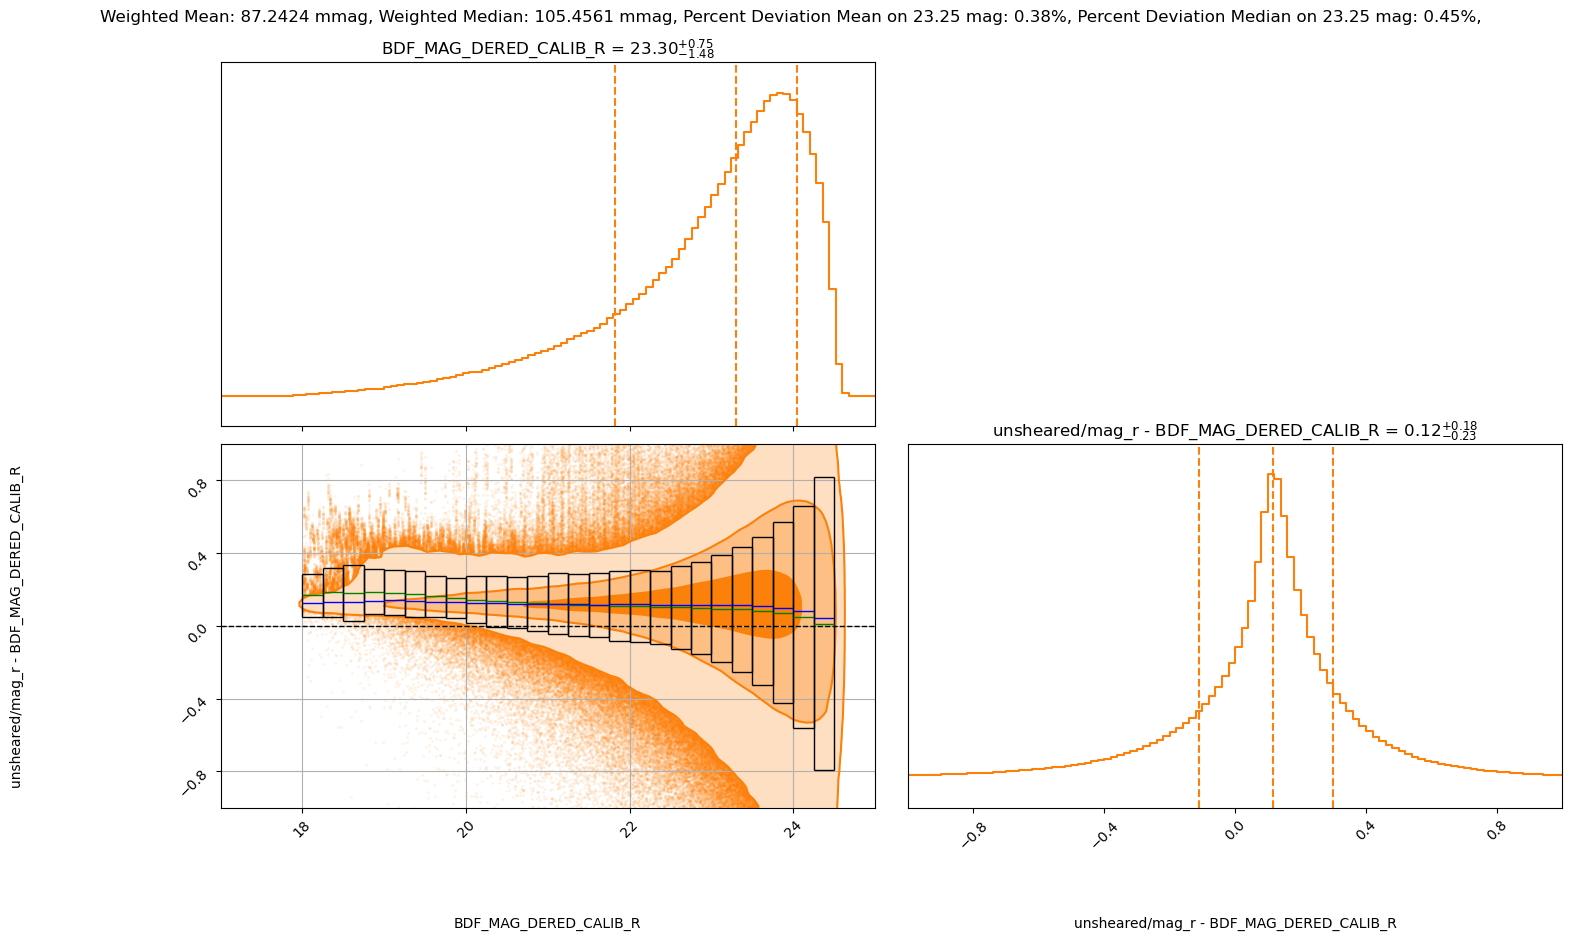

In [11]:
bin_stats_r = plot_bin_offset(
    data_frame=df_balrog,
    true_column="BDF_MAG_DERED_CALIB_R",
    measured_column="unsheared/mag_r",
    color="#fc810a",
    save_name=f"{cfg['PATH_OUTPUT']}/bin_offset_r.png",
    show_plot=cfg["SHOW_PLOT_MOCK"],
    save_plot=cfg["SAVE_PLOT_MOCK"]
)

show plot


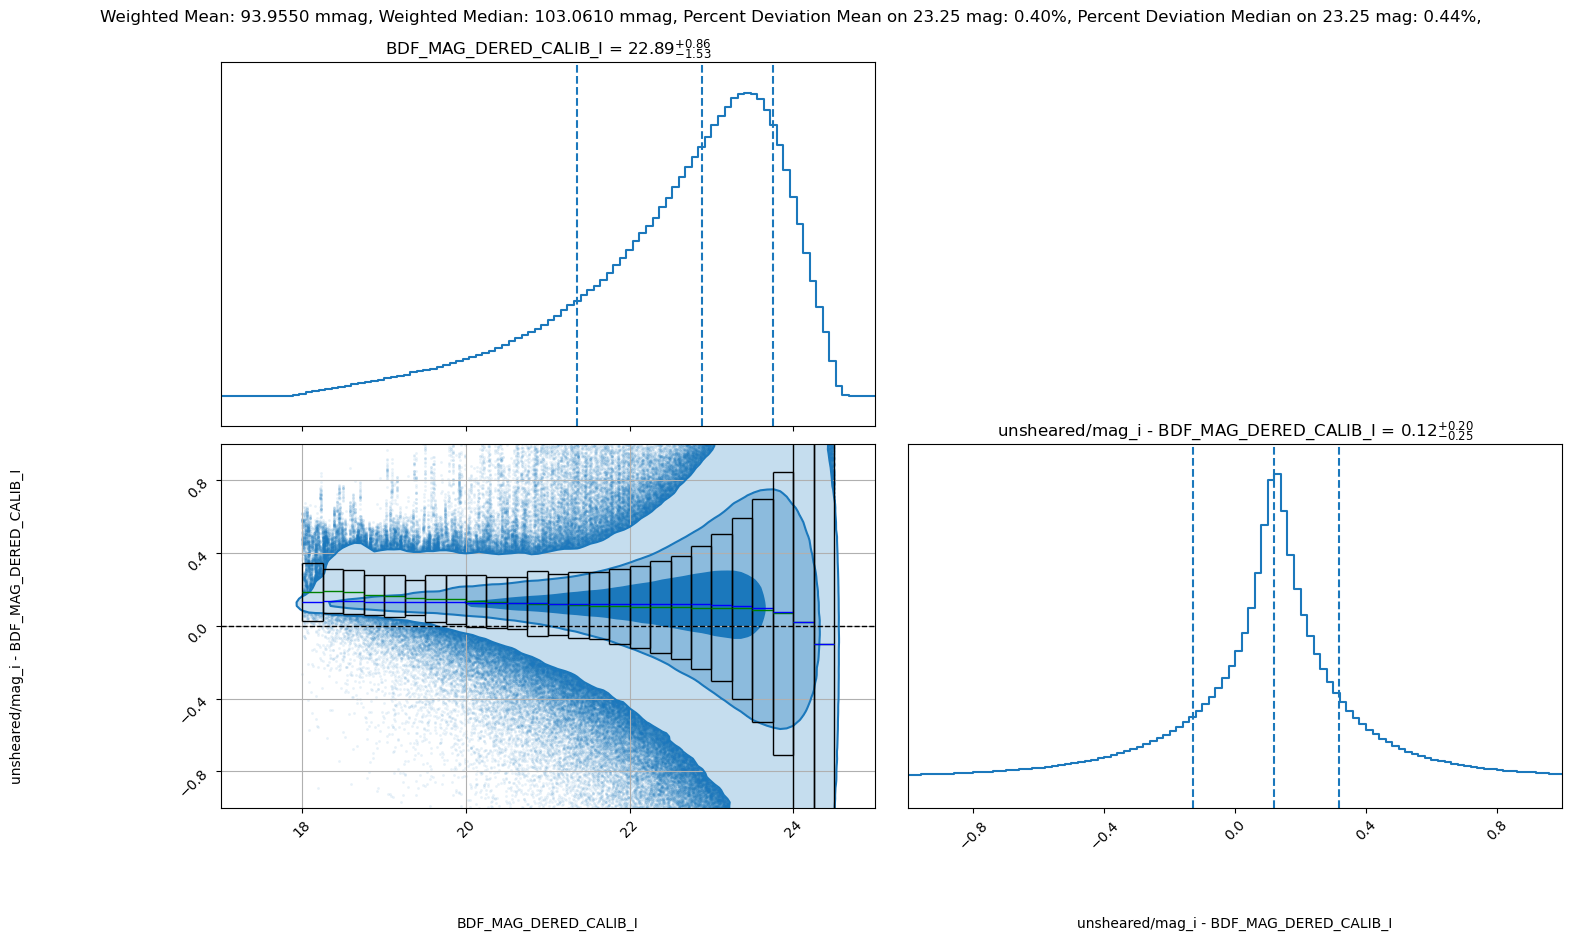

In [12]:

bin_stats_i = plot_bin_offset(
    data_frame=df_balrog,
    true_column="BDF_MAG_DERED_CALIB_I",
    measured_column="unsheared/mag_i",
    color="#1b78bc",
    save_name=f"{cfg['PATH_OUTPUT']}/bin_offset_i.png",
    show_plot=cfg["SHOW_PLOT_MOCK"],
    save_plot=cfg["SAVE_PLOT_MOCK"]
)

show plot


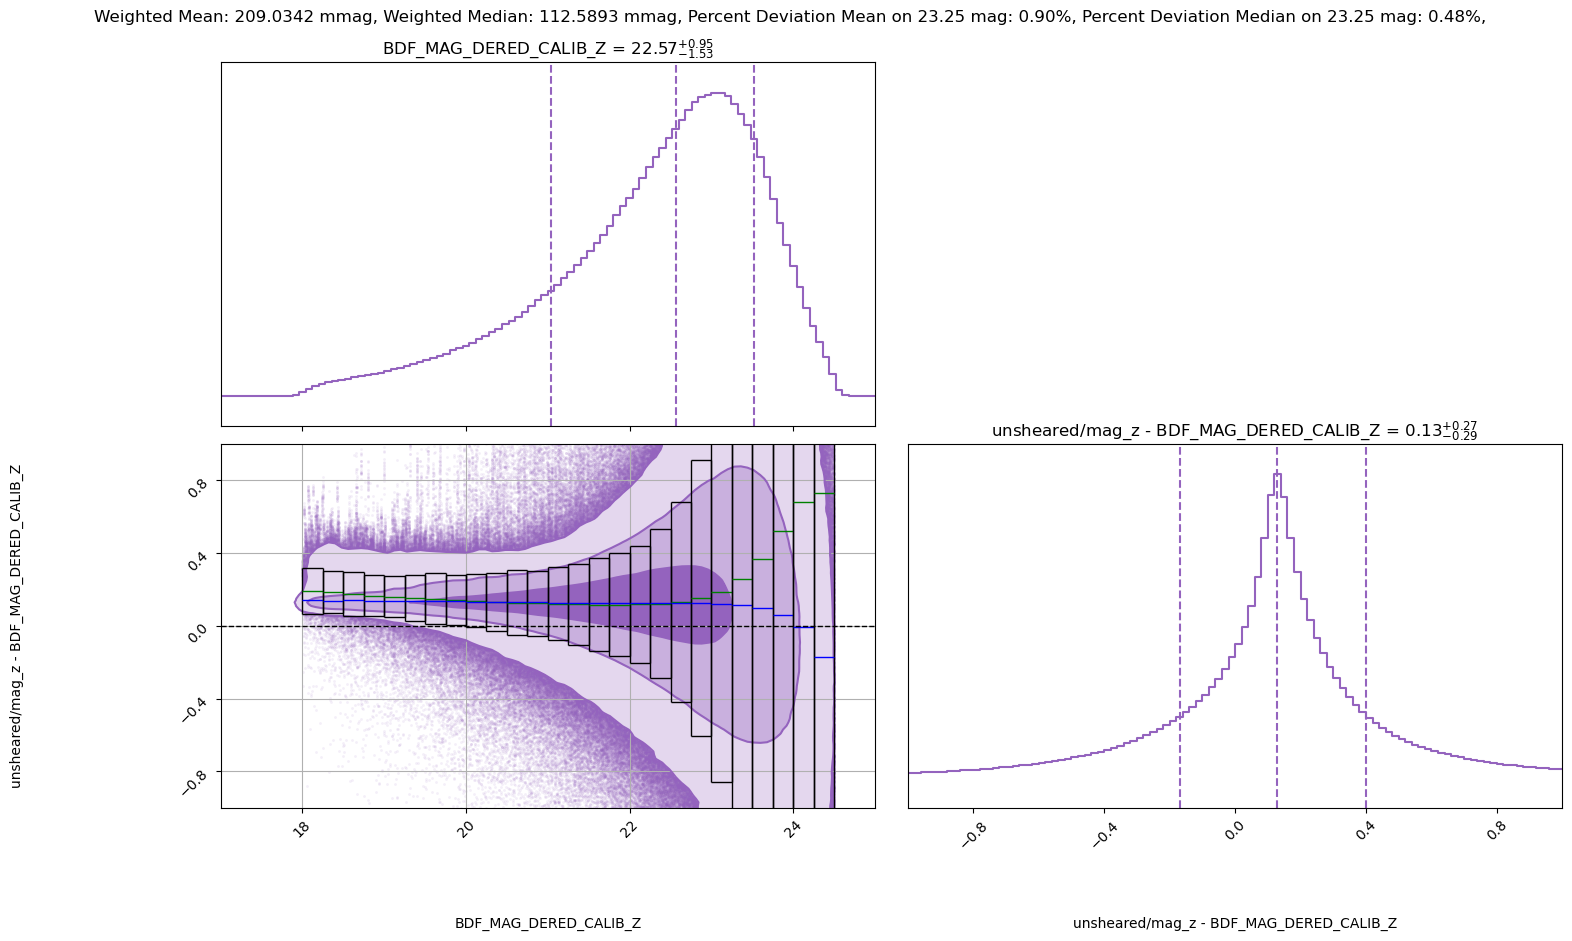

In [13]:

bin_stats_z = plot_bin_offset(
    data_frame=df_balrog,
    true_column="BDF_MAG_DERED_CALIB_Z",
    measured_column="unsheared/mag_z",
    color="#9463be",
    save_name=f"{cfg['PATH_OUTPUT']}/bin_offset_z.png",
    show_plot=cfg["SHOW_PLOT_MOCK"],
    save_plot=cfg["SAVE_PLOT_MOCK"]
)

In [14]:

dict_offset = {
        "weighted_mean_mag_r": bin_stats_r['weighted_mean'],
        "weighted_mean_mag_i": bin_stats_i['weighted_mean'],
        "weighted_mean_mag_z": bin_stats_z['weighted_mean'],
        "weighted_median_mag_r": bin_stats_r['weighted_median'],
        "weighted_median_mag_i": bin_stats_i['weighted_median'],
        "weighted_median_mag_z": bin_stats_z['weighted_median'],
        "percent_deviation_mean_r": bin_stats_r['percent_deviation_mean'],
        "percent_deviation_mean_i": bin_stats_i['percent_deviation_mean'],
        "percent_deviation_mean_z": bin_stats_z['percent_deviation_mean'],
        "percent_deviation_median_r": bin_stats_r['percent_deviation_median'],
        "percent_deviation_median_i": bin_stats_i['percent_deviation_median'],
        "percent_deviation_median_z": bin_stats_z['percent_deviation_median']
    }

## Calculate covariance

In [15]:
df_cov_difference = df_balrog[cfg["COVARIANCE_COLUMNS"]]

# Calculate the IQR for each column
iqr_values = df_cov_difference.apply(iqr)
iqr_values

flux_diff_r    144.892913
flux_diff_i    234.318348
flux_diff_z    370.211056
dtype: float64

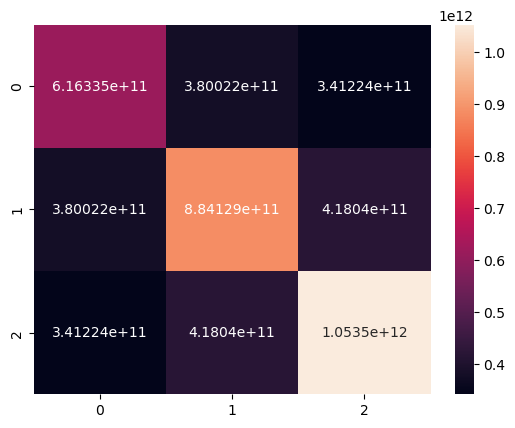

In [16]:
# Create a DataFrame where each cell is the product of the IQRs of its row and column
cov_matrix_difference = df_cov_difference.cov().values
sns.heatmap(cov_matrix_difference, annot=True, fmt='g')
plt.show()

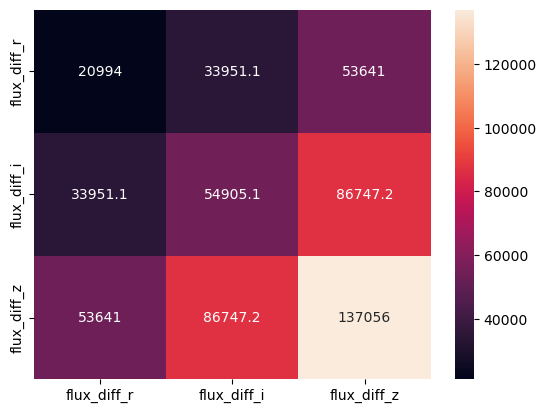

In [17]:
cov_matrix_difference = pd.DataFrame(np.outer(iqr_values, iqr_values), columns=df_cov_difference.columns, index=df_cov_difference.columns)
sns.heatmap(cov_matrix_difference, annot=True, fmt='g')
plt.show()

In [18]:
print(f"covariance matrix deep distribution: {cov_matrix_difference}")

df_temp = df_balrog.copy()
for idx_bin, bin in enumerate(cfg["UNSHEARED_BINS"]):
    df_temp.loc[:, f"Color unsheared mag {bin}-{cfg['UNSHEARED_BINS'][idx_bin+1]}"] = (
            df_temp[f"unsheared/mag_{bin}"].values - df_temp[f"unsheared/mag_{cfg['UNSHEARED_BINS'][idx_bin+1]}"].values
    )
    if idx_bin + 1 == len(cfg["UNSHEARED_BINS"]) - 1:
        break

covariance matrix deep distribution:               flux_diff_r   flux_diff_i    flux_diff_z
flux_diff_r  20993.956230  33951.067956   53640.958249
flux_diff_i  33951.067956  54905.088050   86747.242813
flux_diff_z  53640.958249  86747.242813  137056.225624


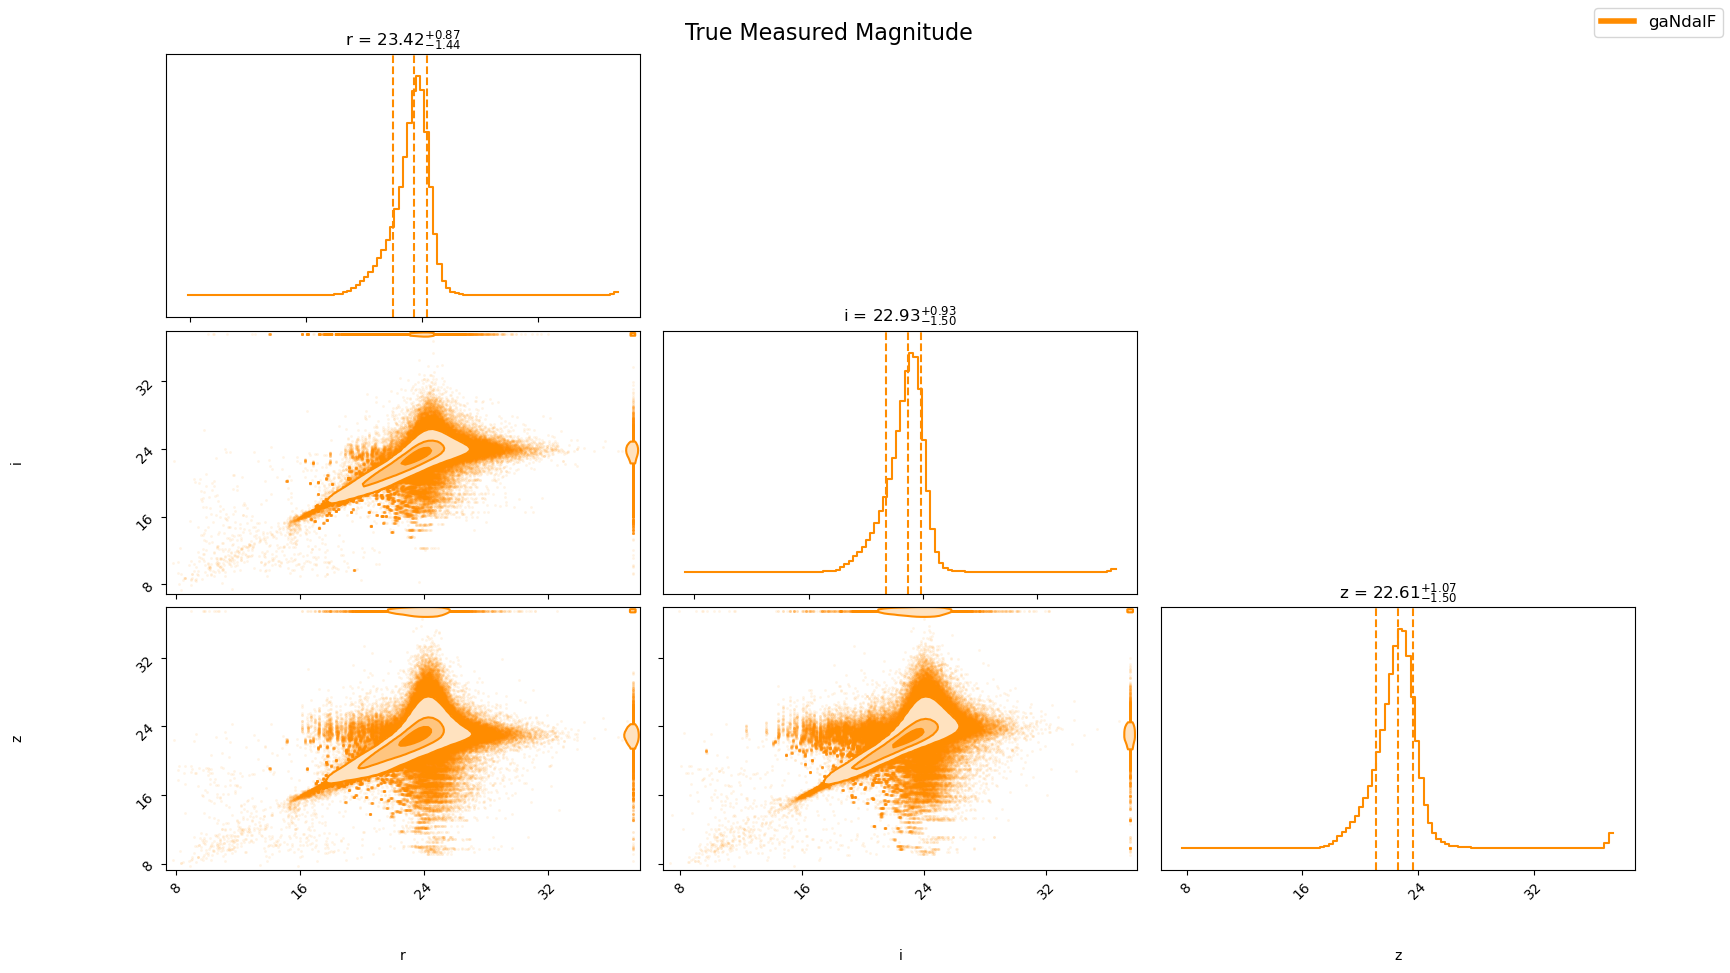

<Figure size 640x480 with 0 Axes>

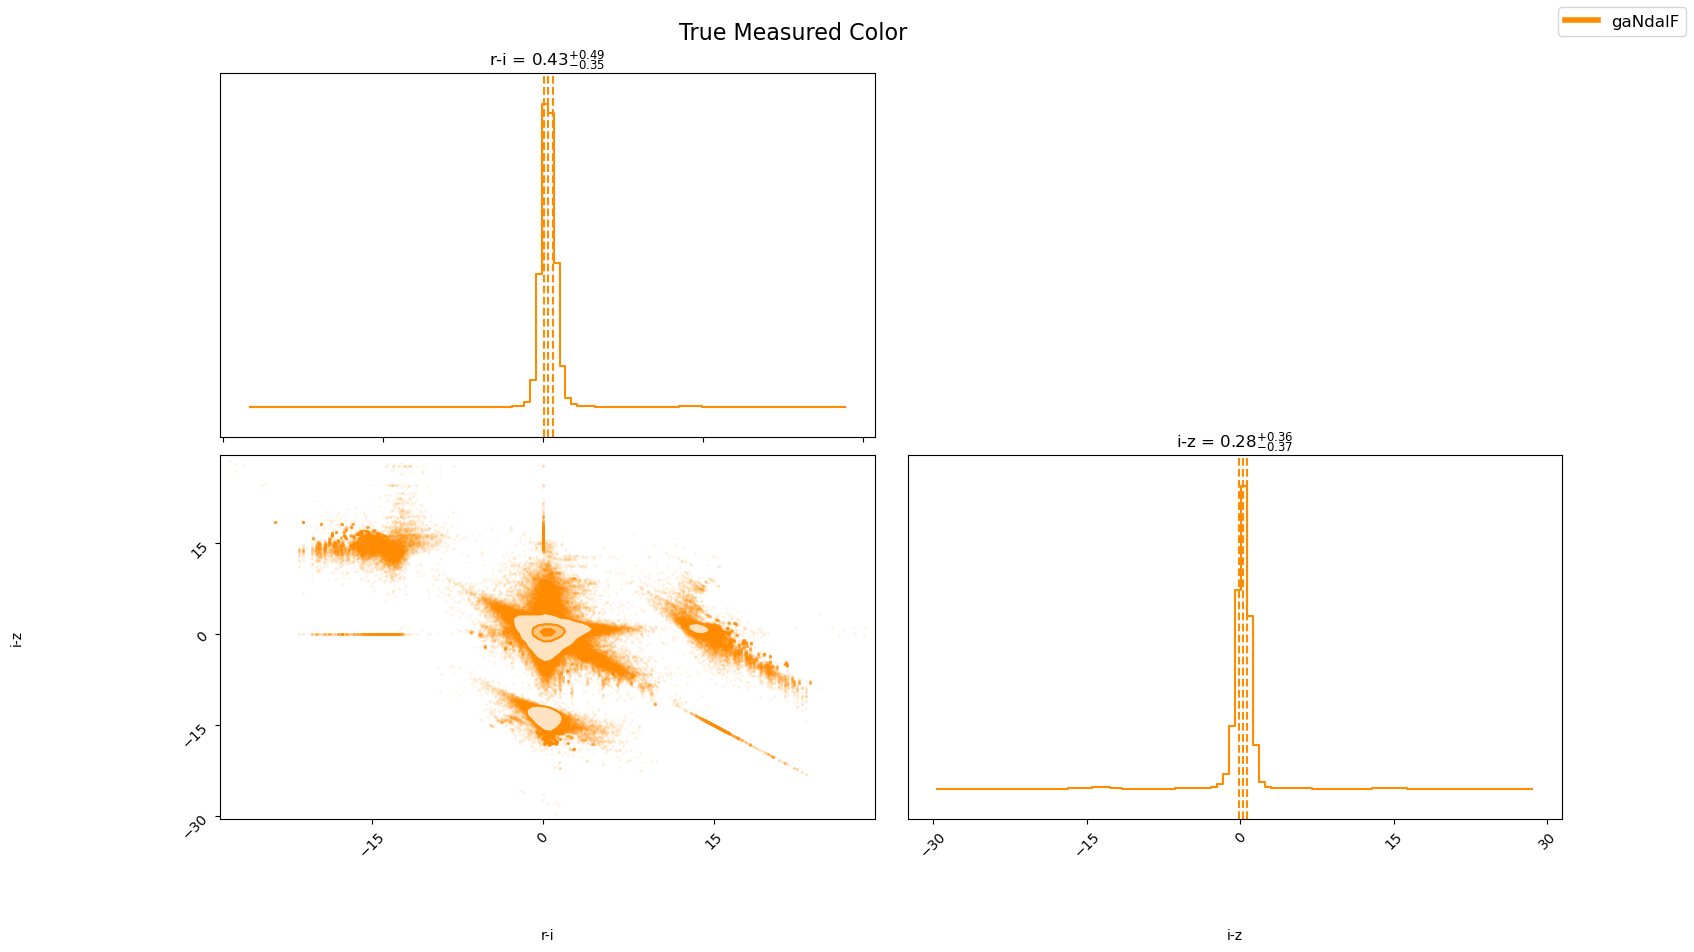

<Figure size 640x480 with 0 Axes>

In [19]:
if cfg["PLOT_TRUE_MEAS_MAG"] is True:
    plot_corner(
        df_temp,
        columns=[
            "unsheared/mag_r",
            "unsheared/mag_i",
            "unsheared/mag_z",
        ],
        labels=["r", "i", "z"],
        title="True Measured Magnitude",
        ranges=None,
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        save_name=f"{cfg['PATH_OUTPUT']}/true_meas_mag.png"
    )
if cfg["PLOT_TRUE_MEAS_COLOR"] is True:
    plot_corner(
        df_temp,
        columns=[
            "Color unsheared mag r-i",
            "Color unsheared mag i-z"
        ],
        labels=["r-i", "i-z"],
        title="True Measured Color",
        ranges=None,
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        save_name=f"{cfg['PATH_OUTPUT']}/true_meas_color.png"
    )

## Plotting

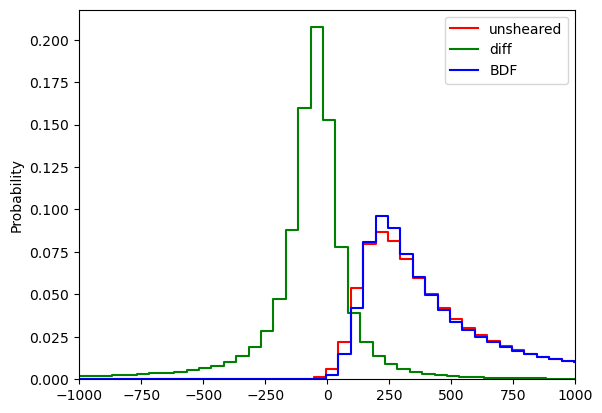

In [20]:
sns.histplot(
    x=df_balrog["unsheared/flux_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"unsheared"
)
sns.histplot(
    x=df_balrog["flux_diff_r"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"diff"
)
sns.histplot(
    x=df_balrog["BDF_FLUX_DERED_CALIB_R"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"BDF"
)
plt.xlim(-1000, 1000)
plt.legend()
plt.show()

In [21]:
df_balrog_cut = apply_cuts(cfg=cfg, data_frame=df_balrog)

Apply unsheared object cuts
Length of catalog after applying unsheared object cuts: 8554517
Apply flag cuts
Length of catalog after applying flag cuts: 7375026
Apply unsheared shear cuts
Length of catalog after applying unsheared shear cuts: 2595330
perform binaries cut


/Users/P.Gebhardt/.conda/envs/GANdalf/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


len w/ binaries 2595011


define mask
pass:  2482872
fail:  112139
Apply unsheared mag cuts
Length of catalog after applying unsheared mag cuts: 2527408


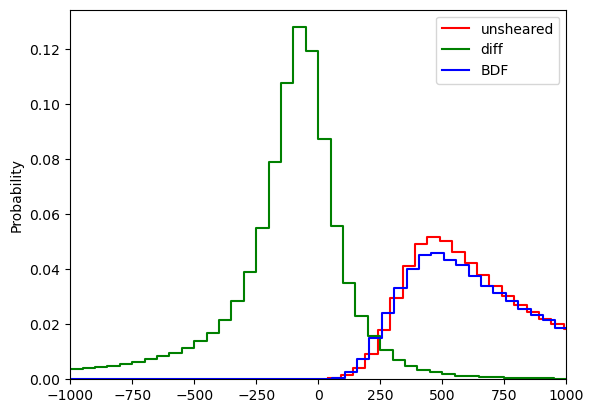

In [22]:
sns.histplot(
    x=df_balrog_cut["unsheared/flux_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"unsheared"
)
sns.histplot(
    x=df_balrog_cut["flux_diff_r"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"diff"
)
sns.histplot(
    x=df_balrog_cut["BDF_FLUX_DERED_CALIB_R"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"BDF"
)
plt.xlim(-1000, 1000)
plt.legend()
plt.show()

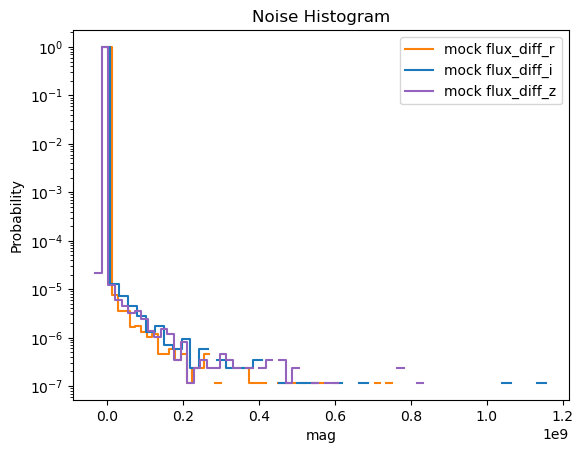

<Figure size 640x480 with 0 Axes>

In [23]:
if cfg["PLOT_MOCK_NOISE"] is True:
    plot_histo(
        data_frame=df_balrog,
        columns=cfg["COVARIANCE_COLUMNS"],
        colors=None,
        bin_size=50,
        log_scale=(False, True),
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        xlabel="mag",
        save_name=f"{cfg['PATH_OUTPUT']}/noise_true_hist.png",
        title=f"Noise Histogram"
    )
    
# df_balrog = df_balrog[cfg["SOMPZ_COLS"]+cfg["COVARIANCE_COLUMNS"]]

In [24]:

print(df_balrog)
print(df_balrog.isna().sum())
print(df_balrog.isna().sum().sum())

                    bal_id    true_id  detected     true_ra   true_dec  \
0             100156035400  691667161         1   29.247997 -35.401742   
1             102037044570  691667161         1  309.631288 -45.133897   
2             100530030400  691667161         1   83.027200 -30.858628   
3             100010040400  691667161         1    2.324426 -40.370944   
4             100521042490  691667161         1   80.463712 -42.748836   
...                    ...        ...       ...         ...        ...   
26442011  1006110391413067  713198821         1   93.037734 -38.904808   
26442021  1005550491413068  713198833         1   88.957615 -49.210830   
26442029  1022230470613069  713198833         1  336.043413 -46.800077   
26442105  1003140354013071  713198866         1   48.359363 -35.539977   
26442115  1001160004113066  713198876         1   19.515271  -0.705690   

          match_flag_1.5_asec  flags_foreground  flags_badregions  \
0                           0             

In [25]:
size = cfg["SIZE_MOCK"]

df_diff = df_balrog[cfg["COVARIANCE_COLUMNS"]]
arr_mean_diff = np.zeros(len(cfg["COVARIANCE_COLUMNS"]))  # df_diff.mean().values

arr_multi_normal_diff = np.random.multivariate_normal(
    arr_mean_diff,
    cov_matrix_difference,
    df_diff.shape[0]
)

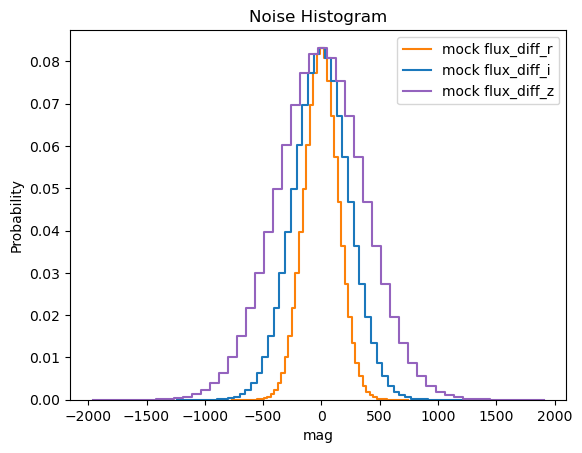

<Figure size 640x480 with 0 Axes>

In [26]:
df_mock = pd.DataFrame(
    arr_multi_normal_diff,
    columns=cfg["COVARIANCE_COLUMNS"]
)
if cfg["PLOT_MOCK_NOISE"] is True:
    plot_histo(
        data_frame=df_mock,
        columns=cfg["COVARIANCE_COLUMNS"],
        colors=None,
        bin_size=50,
        log_scale=(False, False),
        show_plot=cfg["SHOW_PLOT_MOCK"],
        save_plot=cfg["SAVE_PLOT_MOCK"],
        xlabel="mag",
        save_name=f"{cfg['PATH_OUTPUT']}/noise_hist.png",
        title=f"Noise Histogram"
    )


In [27]:
# df_mock["unsheared/flux_err_r"] = df_true["unsheared/flux_err_r"]
# df_mock["unsheared/flux_err_i"] = df_true["unsheared/flux_err_i"]
# df_mock["unsheared/flux_err_z"] = df_true["unsheared/flux_err_z"]

for idx_bin, bin in enumerate(cfg["UNSHEARED_BINS"]):
    new_val = df_balrog[f"BDF_FLUX_DERED_CALIB_{bin.upper()}"].values * 10 ** (-0.4 * dict_offset[f"weighted_mean_mag_{bin}"]) + df_mock[f"flux_diff_{bin}"].values

    # Check if new_val is smaller than min_val, if so, set to min_val
    df_mock[f"unsheared/flux_{bin}"] = new_val  # np.where(new_val < min_val, min_val, new_val)

    df_mock[f"unsheared/mag_{bin}"] = flux2mag(df_mock[f"unsheared/flux_{bin}"].values)
    df_mock[f"BDF_FLUX_DERED_CALIB_{bin.upper()}"] = df_balrog[f"BDF_FLUX_DERED_CALIB_{bin.upper()}"].values
    df_mock[f"BDF_MAG_DERED_CALIB_{bin.upper()}"] = flux2mag(df_balrog[f"BDF_FLUX_DERED_CALIB_{bin.upper()}"].values)

    df_balrog[f"unsheared/mag_{bin}"] = flux2mag(df_balrog[f"unsheared/flux_{bin}"].values)

In [28]:
for idx_bin, bin in enumerate(cfg["UNSHEARED_BINS"]):
    df_mock.loc[:, f"Color unsheared mag {bin}-{cfg['UNSHEARED_BINS'][idx_bin+1]}"] = (
            df_mock[f"unsheared/mag_{bin}"].values - df_mock[f"unsheared/mag_{cfg['UNSHEARED_BINS'][idx_bin+1]}"].values
    )
    if idx_bin + 1 == len(cfg["UNSHEARED_BINS"]) - 1:
        break

In [29]:
print(f"len generated data: {len(df_mock)}")
print(f"len true data: {len(df_balrog)}")
df_mock = df_mock.reset_index(drop=True)
df_true = df_balrog.reset_index(drop=True)

# df_mock = add_needed_columns(
#     data_frame_mock=df_mock,
#     df_true=df_true
# )

len generated data: 8612535
len true data: 8612535


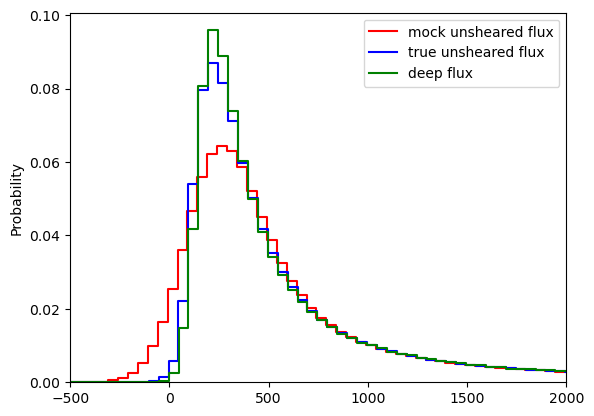

In [33]:
sns.histplot(
    x=df_mock["unsheared/flux_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"mock unsheared flux"
)
sns.histplot(
    x=df_true["unsheared/flux_r"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"true unsheared flux"
)
sns.histplot(
    x=df_true["BDF_FLUX_DERED_CALIB_R"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=50,
    log_scale=(False, False),
    stat="probability",
    label=f"deep flux"
)
plt.xlim(-500, 2000)
plt.legend()
plt.show()

In [107]:
df_mock = apply_cuts(cfg=cfg, data_frame=df_mock)
df_true = apply_cuts(cfg=cfg, data_frame=df_true)
# if cfg["MOCK_APPLY_MAG_CUTS_BEFORE"] is False:
#     print("Apply mag cuts")
#     df_mock = unsheared_mag_cut(data_frame=df_mock)
#     df_true = unsheared_mag_cut(data_frame=df_true)

Apply unsheared object cuts


KeyError: 'unsheared/extended_class_sof'

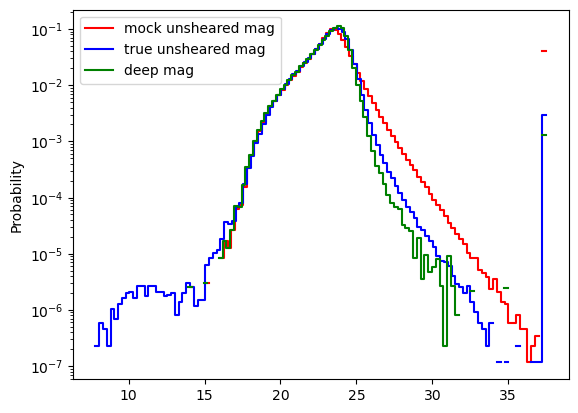

In [34]:

sns.histplot(
    x=df_mock["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="red",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"mock unsheared mag"
)
sns.histplot(
    x=df_true["unsheared/mag_r"].values,
    element="step",
    fill=False,
    color="blue",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"true unsheared mag"
)
sns.histplot(
    x=df_true["BDF_MAG_DERED_CALIB_R"].values,
    element="step",
    fill=False,
    color="green",
    binwidth=0.25,
    log_scale=(False, True),
    stat="probability",
    label=f"deep mag"
)
# plt.xlim(-60000, 60000)
plt.legend()
plt.show()